In [1]:
import pandas as pd
import numpy as np
import matplotlib as matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import os
import datetime as dt
from shapely import wkt
from shapely.geometry import Point, Polygon
import geopandas as gpd
import netCDF4
import xarray as xr
import dask

In [2]:
proj_path = '/Users/etriesch/dev/ocean-carbon-sampling/'
crs = 'epsg:4326'
pd.set_option('display.max_columns', 300)
pd.set_option('display.max_rows', 400)

In [3]:
YEAR_LOOKBACK_MIN = 2017
YEAR_LOOKBACK_MAX = 2022

# Read and clean mooring data

In [9]:
mooring_path = proj_path + 'data/pco2_moorings/'
m_files = [f for f in os.listdir(proj_path + 'data/pco2_moorings') 
           if f.endswith('.csv')]
m_files.sort()

In [10]:
# read in mooring data
m = pd.DataFrame()
for f in m_files:
    skip=4
    d = pd.read_csv(mooring_path + f, skiprows=skip)
    while (d.columns[0] not in ['Mooring', 'Mooring Name']) & (skip >= 0):
        d = pd.read_csv(mooring_path + f, skiprows=skip)
        skip -= 1
    # clean up columns
    d.columns = d.columns.str.lower()
    d.columns = d.columns.str.replace('[()%]','',regex=True)
    d.columns = d.columns.str.replace('  ', ' ').str.replace(' ','_')
    d.columns = d.columns.str.replace(r'_c$', '',regex=True).str.replace(r'_uatm$', '',regex=True)
    d.columns = d.columns.str.replace(r'_umol/mol$', '',regex=True).str.replace(r'_mmol/mol$', '',regex=True)
    d.columns = d.columns.str.replace(r'_ntu$', '',regex=True).str.replace(r'_hpa$', '',regex=True)
    d.columns = d.columns.str.replace(r'_ug/l$', '',regex=True).str.replace(r'umol/kg$', '',regex=True)
    m = pd.concat([m, d], axis=0)

In [11]:
# Clean dataset
# drop unnamed variables
m = m.loc[:, ~m.columns.str.startswith('unnamed')]

# clean up mooring names
m.loc[m['mooring_name'].isna(), 'mooring_name'] = m.loc[m['mooring_name'].isna(), 'mooring']
m.loc[m['mooring_name'].isin(['MS_89W_30N', 'CoastalMS', 'COASTALMS_88W_30N', 'COASTALMS_89W_30N']), 'mooring_name'] = 'COASTALMS_89W_30N'
m.loc[m['mooring_name'].isin(['GRAYSRF_81W_31N','GraysReef','GraysRf_81W_31N', 'GraysReef_81W_31N']), 'mooring_name'] = 'GRAYSRF_81W_31N'
# drop all other rows with missing mooring names (it's missing in all columns)
m = m.loc[m.mooring_name.notna()]

# make new variables
m.loc[:,'date'] = pd.to_datetime(m['date'])
m.loc[:,'year'] = m.date.dt.year
m.loc[:, 'month'] = m.date.dt.month
m.loc[:, 'date'] = m.date.dt.date
m.loc[:, 'moye'] = (m['year'] + m['month'] / 100).astype(str).str.pad(7, 'right', '0')

# subset to variables/years of interest and clean those
params = ['xco2_sw_wet', 'xco2_sw_dry', 'fco2_sw_sat', 'pco2_sw_sat']
m[params] = m[params].apply(pd.to_numeric, errors='coerce')
m[params] = m[params].replace({-999:np.nan})

# subset years and moorings
m_sub = m.loc[(m.year >= YEAR_LOOKBACK_MIN) & (m.year <= YEAR_LOOKBACK_MAX)]
drop_moorings = ['GRAYSRF_81W_31N', 'COASTALMS_89W_30N']
m_sub = m_sub.loc[~m_sub.mooring_name.isin(drop_moorings)].reset_index(drop=True)

## Summarize variability of pCO2

In [12]:
# summarize by month
param = 'pco2_sw_sat'
m_summ = m_sub.groupby(['mooring_name', 'moye', 'year', 'month'])[param].describe().reset_index()
m_summ = m_summ.sort_values(['mooring_name','moye'])

In [48]:
# get max monthly std per mooring
summ_monthly_std = m_summ.groupby('mooring_name')['std'].agg(mean_monthly='mean', max_monthly='max')

In [47]:
# get max annual std per mooring
summ_annual_std = m_sub.groupby(['mooring_name', 'year'])[param].describe().reset_index()
summ_annual_std = summ_annual_std.groupby('mooring_name')['std'].agg(mean_annual='mean', max_annual='max')

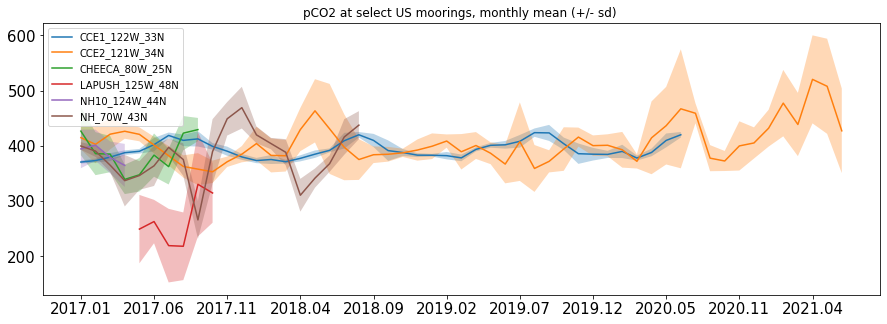

In [50]:
# plot
fit, ax = plt.subplots(figsize=(15,5))
plt.rcParams.update({'font.size': 10})

moorings = m_summ.mooring_name.drop_duplicates().values
for mo in moorings:
    temp = m_summ.loc[m_summ.mooring_name==mo]
    plt.plot(temp.moye, temp['mean'], label=mo)
#     plt.fill_between(temp.moye, temp['25%'], temp['75%'], alpha=0.3) #IQR
#     plt.fill_between(temp.moye, temp['min'], temp['max'], alpha=0.3) #Range
    plt.fill_between(temp.moye, temp['mean']-temp['std'], temp['mean']+temp['std'], alpha=0.3) #STD

axis_spacing = m_summ.moye.drop_duplicates().sort_values().to_list()[::5]
plt.xticks(axis_spacing)
plt.title('pCO2 at select US moorings, monthly mean (+/- sd) ')
plt.legend()
plt.show()

## Summarize variability in change in pCO2

In [16]:
# replace lat/lon with mean
m_sub['lat_cln'] = m_sub.groupby(['mooring_name'])['latitude'].transform('mean')
m_sub['lon_cln'] = m_sub.groupby(['mooring_name'])['longitude'].transform('mean')

In [17]:
# get daily average
m_d = m_sub.groupby(['mooring_name', 'lat_cln', 'lon_cln', 'date'])[param].agg(['mean', 'std']).reset_index()
old_dims = m_d.shape

In [18]:
# get all dates in period for each mooring
date_ranges = m_d.groupby(['mooring_name'])['date'].agg(['min','max'])
dates = pd.DataFrame()
for i in range(date_ranges.shape[0]):
    min_max = date_ranges.iloc[i]
    date = pd.DataFrame({'date': pd.date_range(min_max[0], min_max[1]-pd.to_timedelta(1), freq='d')})
    date['mooring_name'] = date_ranges.index[i]
    date['year'] = date.date.dt.year
    date['month'] = date.date.dt.month
    date['date'] = date.date.dt.date
    date['moye'] = (date['year'] + date['month'] / 100).astype(str).str.pad(7, 'right', '0')
    dates = date.append(dates)

In [19]:
# merge in these rows
m_d = pd.merge(left=m_d, right=dates, how='right', on=['mooring_name', 'date'])
m_d = m_d.sort_values(['mooring_name', 'date']).reset_index(drop=True)
print(f'interpolating {m_d.shape[0] - old_dims[0]} days out of {m_d.shape[0]}, ({(m_d.shape[0] - old_dims[0])/m_d.shape[0]})')

# nearest interpolation of points
m_d['mean'] = (
    m_d.groupby(['mooring_name', 'lat_cln', 'lon_cln', 'date', 'year', 'month', 'moye'])['mean']
    .apply(lambda group: group.interpolate(method='linear')))

interpolating 193 days out of 4010, (0.04812967581047382)


In [20]:
# get 30-day lag
m_d[['lag30', 'date_30lag']] = m_d.groupby('mooring_name')[['mean', 'date']].shift(30)
m_d['delta30'] = m_d['mean'] - m_d.lag30

# get 15-day lag
m_d[['lag15', 'date_15lag']] = m_d.groupby('mooring_name')[['mean', 'date']].shift(15)
m_d['delta15'] = m_d['mean'] - m_d.lag15

# get N-day difference std per mooring
summ_daydiff_std = m_d.groupby('mooring_name').agg(day_diff15=('delta15', 'std'), day_diff30=('delta30','std'))

In [45]:
# get monthly difference std per mooring
m_m = m_d.groupby(['mooring_name', 'year', 'month'])['mean'].describe().reset_index()
m_m['lag_month'] =  m_d.groupby('mooring_name')['mean'].shift(1)
m_m['delta_month'] = m_m['mean'] - m_m.lag_month
summ_monthlyavediff_summ = m_m.groupby(['mooring_name']).agg(mean_month_diff=('delta_month','std'))

## Summarize variability measures at key moorings

In [46]:
pd.concat([summ_annual_std, summ_monthly_std, summ_daydiff_std, summ_monthlyavediff_summ], axis=1).reset_index()

,mooring_name,mean_annual,max_annual,mean_monthly,max_monthly,day_diff15,day_diff30,mean_month_diff
0,CCE1_122W_33N,16.972871,17.932454,7.789251,18.526291,13.026978,15.518921,15.403419
1,CCE2_121W_34N,49.909817,76.411775,35.521862,107.691559,62.390452,61.890338,34.342712
2,CHEECA_80W_25N,46.826584,46.826584,32.865231,43.594769,51.663769,52.028095,31.527560
3,LAPUSH_125W_48N,78.366681,78.366681,62.900029,94.351961,94.939756,99.416825,48.862637
4,NH10_124W_44N,35.247156,35.247156,32.762741,38.977564,43.455263,47.128084,17.856390
5,NH_70W_43N,48.533146,51.985737,25.652530,58.508688,43.521463,57.288966,48.120092


# Read and clean ship data (LDEO)

In [4]:
# Read in data
df = pd.read_csv(proj_path + 'data/LDEO_Database_V2019.csv', dtype={'FILENAME': str})

In [5]:
# Clean
df.columns = df.columns.str.lower()

# make date columns
df.loc[:,'date'] = pd.to_datetime(df['month/day/year'])
df.loc[:,'year'] = df.date.dt.year

# subset to years of interest
df_sub = df.loc[(df.year >= YEAR_LOOKBACK_MIN) & (df.year <= YEAR_LOOKBACK_MAX)]

In [6]:
# Northeast Pacific subset
min_lat, max_lat = 29, 48
min_lon, max_lon = -140, -116
p_mask_lon = (df_sub.lon >= min_lon) & (df_sub.lon <= max_lon)
p_mask_lat = (df_sub.lat >= min_lat) & (df_sub.lat <= max_lat)
df_pac = df_sub[p_mask_lon & p_mask_lat]

#Northwest Atlantic subset
min_lat, max_lat = 20, 48
min_lon, max_lon = -97, -60
a_mask_lon = (df_sub.lon >= min_lon) & (df_sub.lon <= max_lon)
a_mask_lat = (df_sub.lat >= min_lat) & (df_sub.lat <= max_lat)
df_atl = df_sub[a_mask_lon & a_mask_lat]

### Visualize

<AxesSubplot:>

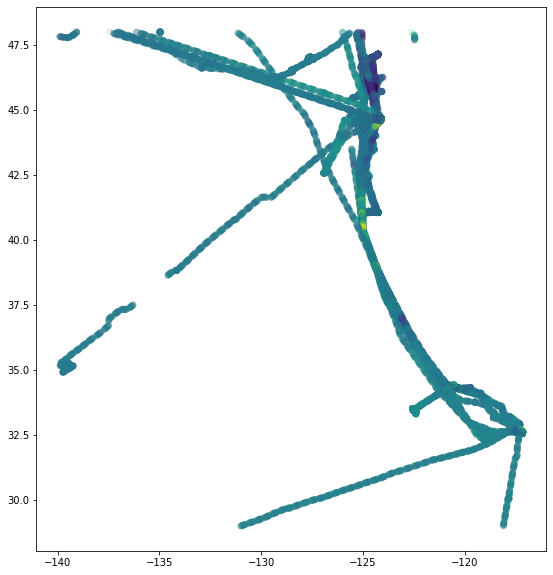

In [7]:
# ship data - pacific
geometry = [Point(xy) for xy in zip(df_pac['lon'], df_pac['lat'])]
geo_df_pac = gpd.GeoDataFrame(df_pac, crs=crs, geometry=geometry)
fig,ax = plt.subplots(figsize=(10,10))
geo_df_pac.plot(ax=ax, column='pco2_teq', alpha=0.1)

<AxesSubplot:>

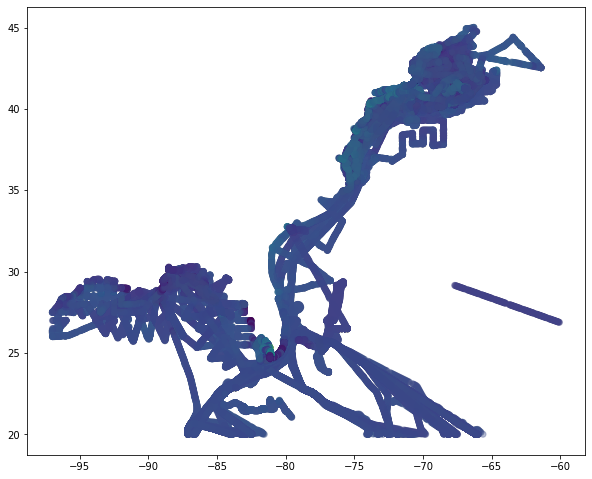

In [8]:
# ship data - atlantic
geometry = [Point(xy) for xy in zip(df_atl['lon'], df_atl['lat'])]
geo_df_atl = gpd.GeoDataFrame(df_atl, crs=crs, geometry=geometry)
fig,ax = plt.subplots(figsize=(10,10))
geo_df_atl.plot(ax=ax, column='pco2_teq', alpha=0.1)